Let's now import the required libraries and load the dataset into our application. The following script imports the required libraries:

From
https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

In [45]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Let's now load the dataset into the memory:

In [46]:
data_set = pd.read_csv("../Dataset/cleanedReviewsDateset100.csv")

The following script displays the shape of the dataset and it also prints the header of the dataset:

In [47]:
print(data_set.shape)

data_set.head()

(99, 28)


,product_id,page,page_order,recommended,date,bugType,haveBugs,invalidPositionOverTime,implementationResponseIssue,invalidContextOverTime,...,objectOutOfBoundForSpecificState,artificialStupidity,invalidValueChange,invalidGraphicalRespresentation,text,hours,username,products,early_access,products_ismissing
0,1144200,1,2,True,01-01-22,na,0,0,0,0,...,0,0,0,0,love the game and would give it a 10 out 10 bu...,35.6,philcrest,31,True,False
1,108600,1,0,True,01-01-22,na,0,0,0,0,...,0,0,0,0,in what can only be described as a simplistic ...,6.5,ultramarine716,17,True,False
2,108600,1,7,False,01-01-22,invalid event occurance over time,1,0,0,0,...,0,0,0,0,fun game ruined by overly punishing update mor...,180.9,kobogen,157,True,False
3,108600,1,8,True,01-01-22,na,0,0,0,0,...,0,0,0,0,im a fan of 1st person graphics and a sucker f...,711.7,intorpere,93,True,False
4,1086940,1,0,True,01-01-22,na,0,0,0,0,...,0,0,0,0,great game in the making will be excessively e...,24.9,elkraf,46,True,False


Let's now plot the comment count for each label. To do so, we will first filter all the label or output columns.

In [48]:
bug_categories_labels = data_set[["invalidPositionOverTime", "implementationResponseIssue", "invalidContextOverTime", "interruptedEvent", 
                        "invalidEventOccurraceOverTime","actionNotPossible","actionWhenNotAllowed","informationOutOfOrder","lackOfRequiredInformation",
                        "invalidInfoAccess","objectOutOfBoundForAnyState","objectOutOfBoundForSpecificState","artificialStupidity","invalidValueChange",
                        "invalidGraphicalRespresentation"]]
bug_categories_labels.head()

,invalidPositionOverTime,implementationResponseIssue,invalidContextOverTime,interruptedEvent,invalidEventOccurraceOverTime,actionNotPossible,actionWhenNotAllowed,informationOutOfOrder,lackOfRequiredInformation,invalidInfoAccess,objectOutOfBoundForAnyState,objectOutOfBoundForSpecificState,artificialStupidity,invalidValueChange,invalidGraphicalRespresentation
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


will plot bar plots that show the total comment counts for different labels.

<AxesSubplot:>

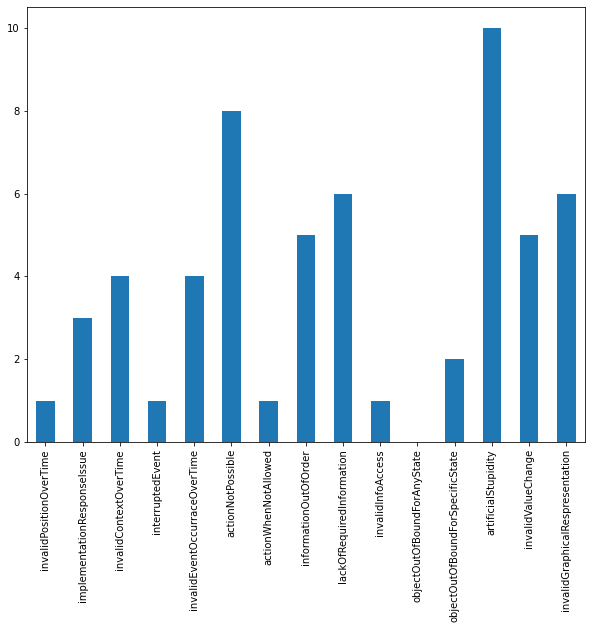

In [49]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

bug_categories_labels.sum(axis=0).plot.bar()

Creating Multi-label Text Classification Models:
There are two ways to create multi-label classification models: Using single dense output layer and using multiple dense output layers.

In the first approach, we can use a single dense layer with six outputs with a sigmoid activation functions and binary cross entropy loss functions. Each neuron in the output dense layer will represent one of the six output labels. The sigmoid activation function will return a value between 0 and 1 for each neuron. If any neuron's output value is greater than 0.5, it is assumed that the comment belongs to the class represented by that particular neuron.

In the second approach we will create one dense output layer for each label. We will have a total of 6 dense layers in the output. Each layer will have its own sigmoid function.

Multi-lable Text Classification Model with Single Output Layer:

In [50]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In the next step we will create our input and output set.

In [51]:
X = []
sentences = list(data_set["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = bug_categories_labels.values

Here we do not need to perform any one-hot encoding because our output labels are already in the form of one-hot encoded vectors.

In the next step, we will divide our data into training and test sets:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=89,test_size=0.10, random_state=42)

We need to convert text inputs into embedded vectors.

In [53]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

In [54]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('../kaggle/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

The following script creates the model. Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 6 neurons since we have 6 labels in the output.

In [55]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(15, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Let's print the model summary:

In [56]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          185500    
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 15)                1935      
                                                                 
Total params: 304,683
Trainable params: 119,183
Non-trainable params: 185,500
_________________________________________________________________
None


The following script prints the architecture of our neural network:

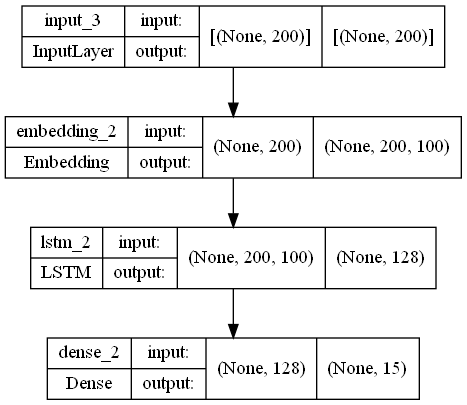

In [57]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Let's now train our model:

In [58]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6958 - acc: 0.0423 - val_loss: 0.6890 - val_acc: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 174ms/step - loss: 0.6863 - acc: 0.0141 - val_loss: 0.6817 - val_acc: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 174ms/step - loss: 0.6777 - acc: 0.0141 - val_loss: 0.6747 - val_acc: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 176ms/step - loss: 0.6693 - acc: 0.0141 - val_loss: 0.6677 - val_acc: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 165ms/step - loss: 0.6609 - acc: 0.0141 - val_loss: 0.6605 - val_acc: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 165ms/step - loss: 0.6521 - acc: 0.0141 - val_loss: 0.6530 - val_acc: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 173ms/step - loss: 0.6425 - acc: 0.0141 - val_loss: 0.6445 - val_acc: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0s 178m

Let's now evaluate our model on the test set:

In [59]:
score = model.evaluate(X_test, y_test, verbose=1)


print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1/1 [==============================] - 0s 32ms/step - loss: 0.3000 - acc: 0.0000e+00
Test Score: 0.300048828125
Test Accuracy: 0.0


Finally, we will plot the loss and accuracy values for training and test sets to see if our model is overfitting.

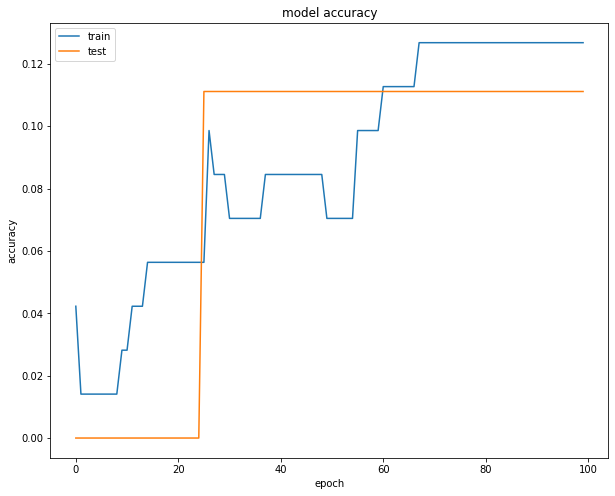

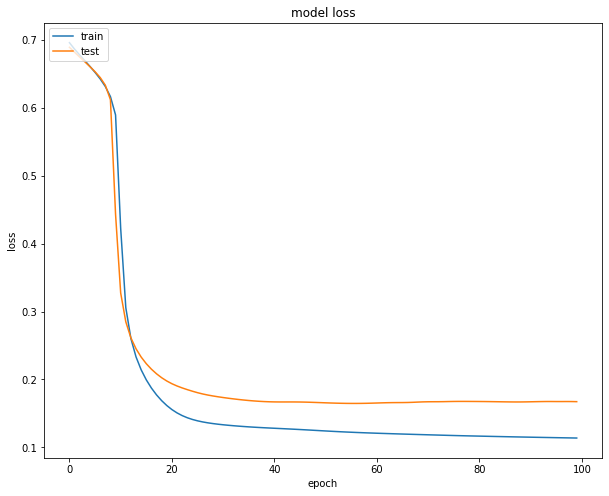

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()